In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import os
import re
import seaborn as sns

%matplotlib widget

data_path = "data/"
train_lidar_path = data_path + "train_lidar/"
train_labels_path = data_path + "train_infos/"

img_dir = "img/"

classes = {
    "Car": 0,
    "Truck": 1,
    "Bus": 2,
    "Pedestrian": 3,
    "Cyclist": 4
}

# get cmap from matplotlib
cm_viridis = mpl.cm.get_cmap('viridis')
cm_hsv = mpl.cm.get_cmap('hsv')
cm_gp2 = mpl.cm.get_cmap('gnuplot2')
cm_gistrb = mpl.cm.get_cmap('gist_rainbow')
cm_rb = mpl.cm.get_cmap('rainbow')

class_colors = {
    name : color
    for name, color in zip(classes.keys(), cm_rb(np.linspace(0, 1, len(classes))))
}

285.6666666666667


NotImplementedError: Axes3D currently only supports the aspect argument 'auto'. You passed in 'equal'.

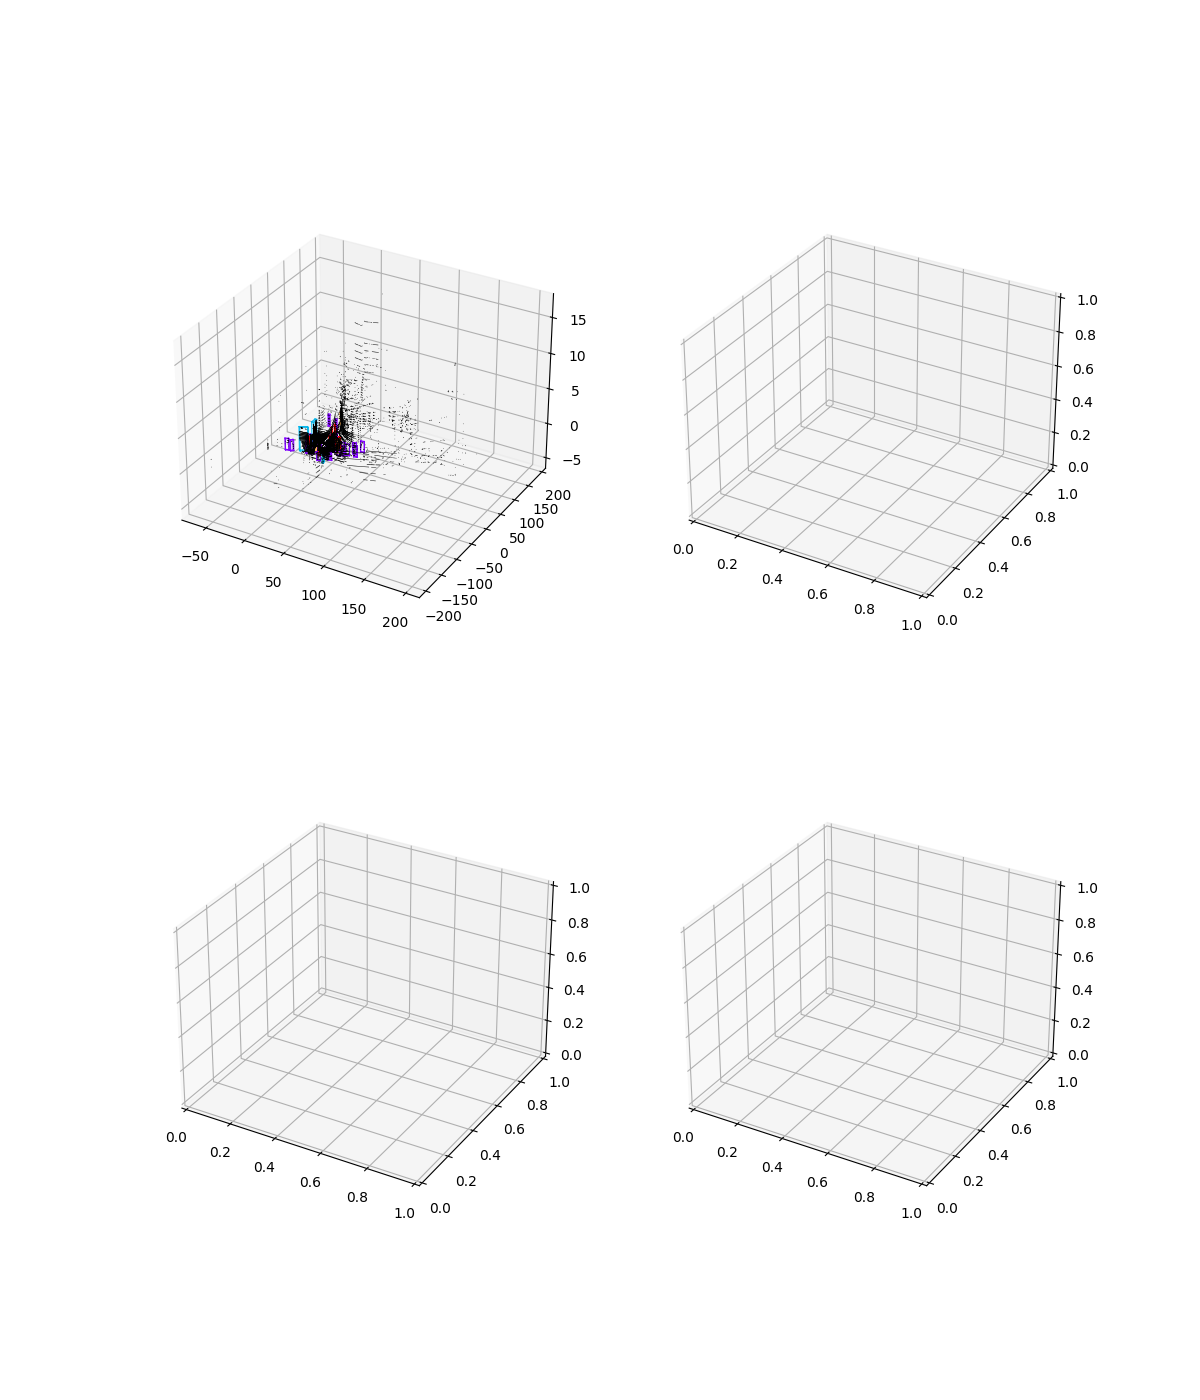

In [5]:
# Read labels from json
scene_set = "000121"

# read point cloud
scene_dir = train_lidar_path + f"data/{scene_set}/lidar_roof/"
all_scenes_pc = [f.path for f in os.scandir(scene_dir) if f.is_file()]
all_scenes_pc.sort(key = lambda x : int(re.sub("\D", "", x)))

print(len(all_scenes_pc) / 6)

scene_nos = list(map(lambda x : x * 280, [0, 2, 4, 6])) # Only even number data points have annotations

# create subplots
fig, axs = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(12, 14))

# zoom setup
zoom = 4
lim = (-100 / zoom, 100 / zoom)

# style
face_color = "#f9f9f9"

for scene_no, ax in zip(scene_nos, axs.flatten()):

    # scene_no = 0
    flabels = train_labels_path + f"data/{scene_set}/{scene_set}.json"

    with open(flabels) as f:
        labels = json.load(f)

    # get annotations from first scene
    annotations = labels["frames"][scene_no]["annos"]


    # plot all bounding boxes in the scene
    for name, box in zip(annotations["names"], annotations["boxes_3d"]):
        # center_x, center_y, center_z, l, w, h, yaw

        # find the corners of the box
        center_x, center_y, center_z, l, w, h, yaw = box

        corners_x = np.array([[l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]]).T
        corners_y = np.array([[w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]]).T
        corners_z = np.array([[h/2, h/2, h/2, h/2, -h/2, -h/2, -h/2, -h/2]]).T
        points = np.hstack((corners_x, corners_y, corners_z))

        # rotation matrix
        R = np.array([[np.cos(-yaw), -np.sin(-yaw), 0],
                      [np.sin(-yaw),  np.cos(-yaw), 0],
                      [           0,             0, 1]])
        # rotate the box
        points = points @ R

        # offset the box with center position
        points[:, 0] += center_x
        points[:, 1] += center_y
        points[:, 2] += center_z

        # colors
        line_c = class_colors[name]
        line_a = 1
        line_w = 0.75

        # plot 12 lines of bounding box
        for i in range(4):
            ax.plot3D(points[[i, i+4], 0], points[[i, i+4], 1], points[[i, i+4], 2], c=line_c, alpha=line_a, linewidth=line_w)
        for i in range(4):
            ax.plot3D(points[[i, (i+1)%4], 0], points[[i, (i+1)%4], 1], points[[i, (i+1)%4], 2], c=line_c, alpha=line_a, linewidth=line_w)
        for i in range(4):
            ax.plot3D(points[[i+4, (i+1)%4+4], 0], points[[i+4, (i+1)%4+4], 1], points[[i+4, (i+1)%4+4], 2], c=line_c, alpha=line_a, linewidth=line_w)

    point_cloud = np.fromfile(all_scenes_pc[scene_no], dtype=np.float32).reshape(-1, 4)

    # plot the point cloud in 3D
    ax.scatter3D(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=0.2, edgecolors="none", c="black", alpha=1)

    # plot setup
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(f"Scene {int(scene_no/2)}")

    # zooming
    ax.set_xlim3d(lim[0], lim[1])
    ax.set_ylim3d(lim[0], lim[1])
    ax.set_zlim3d(lim[0], lim[1])
    ax.set_axis_off()

    ax.set_facecolor(face_color)

fig.legend([mpl.patches.Patch(color=color, label=name) for name, color in class_colors.items()],
           [name for name, color in class_colors.items()],
           loc="lower center",
           ncol=5,
           bbox_to_anchor=(0.5, 0.0),
           frameon=False
)

# fig.tight_layout(pad=2)
fig.tight_layout(rect=[0, 0.025, 1, 0.95])
fig.suptitle(f"Point clouds with Bounding Box annotation from scene {scene_set}", fontsize=16)

# save as png and pdf
fig.savefig(img_dir + f"png/point_clouds_{scene_set}.png", dpi=300)
fig.savefig(img_dir + f"pdf/point_clouds_{scene_set}.pdf")

plt.show()